# KNMI data visualization

<em>TODO: WRITE INTRODUCTION</em>

In the [previous Notebook in the series](./01-knmi_data_retrieval.ipynb) we dived into several showcased examples for data retrieval from the KNMI web script service. In this notebook we will build upon the gained knowledge and show examples of data analysis that can be done with the freely available KNMI dataset.

### Disclaimer
I am not officially affiliated with KNMI, and the scripts and insights provided in this Jupyter Notebook are offered on an unofficial basis for educational and exploratory purposes.

## Preparation steps
We will start by importing the required external and internal modules, scripts and libraries.

### Import external libraries
Note: these are only the external libraries used directly within this Notebook. The Python helper scripts, imported in the subsequent step, may require the installation of additional libraries.

In [1]:
import datetime
import pandas as pd

### Internal imports
In the code below the custom Python helper scripts powering the workflow in this Jupyter Notebook are imported.

In [2]:
import knmi_meteo_ingest
import knmi_meteo_transform
import knmi_meteo_visualize

## Data analysis examples

The aim of showcasing different examples is to give you a hands-on idea on the possibilities, so that you can follow along and experiment further if desired.

The examples that we will focus on in this Jupyter Notebook are:
<ol>
<li>Analysis of temporal patterns of maximum rainfall, wind and temperature</li>
<li>Exploration of spatial patterns of irradiance, precipitaion, temperature, and wind power</li>
</ol>

## Section 1: Parameter-based temporal patterns

In this section we will work through examples of parameter-based temportal patterns by analyzing hour slot occurrences, which enables us to answer questions such as:
- Which time(s) of the day tend to have the highest rainfall intensity?
- When on the day is the warmest moment?
- When is it the windiest?

Moreover, we will take a look at the long-term trends for each of these.

### Example 1.1: Summarize occurrences of rainiest hour slots throughout The Netherlands for a specific year

#### Obtain the raw dataset from the KNMI web service

Let's start by loading the following parameters from the KNMI web service - both are available in the day-based dataset which we will import below:
- Maximum hourly rainfall (RHX)
- Hour slot in which maximum hourly rainfall was measured (RHXH)

In this example, we set 2023 as our year of interest. Feel free to change this to another year if desired.

In [116]:
# Set year of interest as variable
YEAR = 2023

In [117]:
# Set start and end dates (inclusive) for data retrieval
start_date = datetime.date(YEAR, 1, 1)
end_date = datetime.date(YEAR, 12, 31)

# Optional: uncomment below to make end_date exclusive
# end_date -= datetime.timedelta(days=1)

In [118]:
# Get dataset from KNMI web script service
df_day = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                            meteo_params_list=["RHX", "RHXH"],
                                            start_date=start_date,
                                            end_date=end_date)

#### Clean (transform) dataset
We can improve the readability of the dataset by applying some preset transformations on the "raw" dataset we just ingested. 

As part of this transformation, all parameters are converted to whole units of measurements (e.g. $m/s$, $J/cm^2$, $°C$) for better interpretability. Furthermore the column names are converted to a more readable format.

In [119]:
# Apply transformations to the raw dataset
df_day_cleaned = knmi_meteo_transform.transform_param_values(df_day)

In [120]:
# Show the result
df_day_cleaned

,station_code,date,max_rain_hour_sum,hour_slot_max_rain_hour_sum
0,209,2023-01-01,NaN,NaN
1,209,2023-01-02,NaN,NaN
2,209,2023-01-03,NaN,NaN
3,209,2023-01-04,NaN,NaN
4,209,2023-01-05,NaN,NaN
...,...,...,...,...
17150,391,2023-12-27,1.7,8.0
17151,391,2023-12-28,0.0,1.0
17152,391,2023-12-29,5.0,20.0
17153,391,2023-12-30,0.0,1.0


#### Summarize dataset

In [121]:
# Get distribution overview of numeric cols
df_day_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
station_code,17155.0,297.361702,46.271796,209.0,260.0,286.0,331.0,391.0
max_rain_hour_sum,12045.0,1.058983,1.930845,0.0,0.0,0.2,1.5,32.4
hour_slot_max_rain_hour_sum,12045.0,7.463097,7.873316,1.0,1.0,3.0,14.0,24.0


In [123]:
# Only keep columns of interest (this is already the case)
df_max_rain_h = df_day_cleaned.copy()

# Show the result
df_max_rain_h

,station_code,date,max_rain_hour_sum,hour_slot_max_rain_hour_sum
0,209,2023-01-01,NaN,NaN
1,209,2023-01-02,NaN,NaN
2,209,2023-01-03,NaN,NaN
3,209,2023-01-04,NaN,NaN
4,209,2023-01-05,NaN,NaN
...,...,...,...,...
17150,391,2023-12-27,1.7,8.0
17151,391,2023-12-28,0.0,1.0
17152,391,2023-12-29,5.0,20.0
17153,391,2023-12-30,0.0,1.0


#### Mark dry days separately in the dataset

Although this might sound strange, even in The Netherlands we encounter the occasional dry day. To ensure that we will not accidentally count those along in our analysis, potentially distorting our final visualizations, we will mark them separately for now. We do so by marking the hour slot value as "-1" in those cases. 

In this way, this portion of the data will not show up as NaNs (actually missing data), while simultaneously not being part of the hour slot counts for rainy days (1-24) either.

In [124]:
# Filter for dry days
is_dry = df_max_rain_h["max_rain_hour_sum"] < 0.1

# Set hour slot for dry days to -1
df_max_rain_h.loc[is_dry,
                  "hour_slot_max_rain_hour_sum"] = -1

# Show the result
df_max_rain_h

,station_code,date,max_rain_hour_sum,hour_slot_max_rain_hour_sum
0,209,2023-01-01,NaN,NaN
1,209,2023-01-02,NaN,NaN
2,209,2023-01-03,NaN,NaN
3,209,2023-01-04,NaN,NaN
4,209,2023-01-05,NaN,NaN
...,...,...,...,...
17150,391,2023-12-27,1.7,8.0
17151,391,2023-12-28,0.0,-1.0
17152,391,2023-12-29,5.0,20.0
17153,391,2023-12-30,0.0,-1.0


Since we have marked the dry days separately at this point, we only need the hour slot values from here onwards. 

We can therefore now safely drop the <code>max_rain_hour_sum</code> column as in the cell below.

In [12]:
# Remove "max_rain_hour_sum" column
drop_cols = ["max_rain_hour_sum"]
df_max_rain_h = df_max_rain_h.drop(columns=drop_cols)

In [13]:
# Show the result
df_max_rain_h

,date,station_code,hour_slot_max_rain_hour_sum
0,2023-01-01,209,NaN
1,2023-01-02,209,NaN
2,2023-01-03,209,NaN
3,2023-01-04,209,NaN
4,2023-01-05,209,NaN
...,...,...,...
17150,2023-12-27,391,8.0
17151,2023-12-28,391,-1.0
17152,2023-12-29,391,20.0
17153,2023-12-30,391,-1.0


#### Pivoting our way to success

At this point we are left with a "long" format DataFrame, where each row in the DataFrame represents a single hour slot value for a given day and station. 

However, our desired DataFrame, should have the day as the index, the station as the column, and the hour slot as value ("wide" format).

In order to reformat the DataFrame as desired, we apply a pivot function in the cells below.

In [14]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_max_rain_h_pivot = (df_max_rain_h
                       .pivot(index="date",
                              columns="station_code"))

# Flatten pivot table to single index
df_max_rain_h_pivot.columns = (df_max_rain_h_pivot.columns
                               .get_level_values(1))

In [15]:
df_max_rain_h_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,21.0,NaN,22.0,21.0,NaN,NaN,21.0,21.0,20.0,...,NaN,20.0,20.0,19.0,20.0,8.0,9.0,19.0,17.0,19.0
2023-01-02,NaN,5.0,NaN,4.0,14.0,NaN,NaN,5.0,2.0,4.0,...,NaN,3.0,16.0,6.0,17.0,7.0,7.0,8.0,17.0,8.0
2023-01-03,NaN,24.0,NaN,24.0,24.0,NaN,NaN,24.0,18.0,24.0,...,NaN,24.0,24.0,24.0,24.0,24.0,9.0,9.0,-1.0,9.0
2023-01-04,NaN,1.0,NaN,3.0,8.0,NaN,NaN,6.0,3.0,6.0,...,NaN,8.0,10.0,1.0,1.0,13.0,2.0,16.0,13.0,14.0
2023-01-05,NaN,16.0,NaN,18.0,16.0,NaN,NaN,18.0,19.0,16.0,...,NaN,16.0,16.0,16.0,16.0,20.0,17.0,16.0,16.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,8.0,NaN,10.0,9.0,NaN,NaN,9.0,12.0,9.0,...,NaN,8.0,8.0,6.0,8.0,6.0,8.0,6.0,7.0,8.0
2023-12-28,NaN,23.0,NaN,22.0,22.0,NaN,NaN,-1.0,19.0,22.0,...,NaN,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2023-12-29,NaN,17.0,NaN,-1.0,16.0,NaN,NaN,2.0,22.0,10.0,...,NaN,15.0,15.0,14.0,23.0,13.0,14.0,16.0,8.0,20.0


#### Remove stations with substantial missing data

In this analysis we will remove stations that have more than 10% of missing (NaN) data points. This means that all stations with more than 328 days of measured data will remain part of the final analysis. This seems reasonable for the purpose of finding averaged hourly patterns for the maximum rainfall intensity. 

As we will see later (mainly in the next Section), other uses of similar data will require more stringent settings.

Note that KNMI data usually does not tend to contain many NaNs, so changing the fraction cutoff in the cell below should normally not have a lot of impact (unless there is a long-term service disruption).

In [125]:
# Only keep cols if less than fraction of values missing
max_na_frac = 0.10

# Select columns to keep (using the condition)
keep_cols = [col for col in df_max_rain_h_pivot.columns 
             if (df_max_rain_h_pivot[col].isna().mean() 
                 <= max_na_frac)]

# Apply selection to our DataFrame
df_max_rain_h_pivot = df_max_rain_h_pivot[keep_cols]

In [126]:
df_max_rain_h_pivot

station_code,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,21.0,22.0,21.0,21.0,21.0,20.0,20.0,3.0,21.0,24.0,...,19.0,20.0,20.0,19.0,20.0,8.0,9.0,19.0,17.0,19.0
2023-01-02,5.0,4.0,14.0,5.0,2.0,4.0,6.0,5.0,15.0,5.0,...,2.0,3.0,16.0,6.0,17.0,7.0,7.0,8.0,17.0,8.0
2023-01-03,24.0,24.0,24.0,24.0,18.0,24.0,24.0,24.0,24.0,24.0,...,24.0,24.0,24.0,24.0,24.0,24.0,9.0,9.0,-1.0,9.0
2023-01-04,1.0,3.0,8.0,6.0,3.0,6.0,10.0,3.0,9.0,3.0,...,1.0,8.0,10.0,1.0,1.0,13.0,2.0,16.0,13.0,14.0
2023-01-05,16.0,18.0,16.0,18.0,19.0,16.0,18.0,17.0,20.0,19.0,...,14.0,16.0,16.0,16.0,16.0,20.0,17.0,16.0,16.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,8.0,10.0,9.0,9.0,12.0,9.0,8.0,11.0,9.0,12.0,...,5.0,8.0,8.0,6.0,8.0,6.0,8.0,6.0,7.0,8.0
2023-12-28,23.0,22.0,22.0,-1.0,19.0,22.0,23.0,22.0,24.0,22.0,...,-1.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2023-12-29,17.0,-1.0,16.0,2.0,22.0,10.0,16.0,2.0,17.0,22.0,...,13.0,15.0,15.0,14.0,23.0,13.0,14.0,16.0,8.0,20.0


Great - after removing the stations with "excess" NaN values we can now work further with the remaining dataset.

#### Convert hour slot observations to "counts"

In the cell below we will summarize the remaining dataset by converting it into an aggregated DataFrame of hour slot counts for the period if interest. We do so by making use of the built-in Pandas DataFrame method <code>.value_counts()</code> followed by a re-indexing to hour slots in the cell below:

In [18]:
# Placeholder for DataFrame of counts
df_max_rain_h_counts = pd.DataFrame()

# Build up the 'counts' DataFrame col by col
for col in df_max_rain_h_pivot.columns:
    df_max_rain_h_counts[col] = (df_max_rain_h_pivot[col]
                                 .value_counts())

# Order the hour slots in index; ascending
df_max_rain_h_counts.sort_index(ascending=True,
                                inplace=True)

# Rename index
df_max_rain_h_counts.index.names = ['hour_slot']

In [19]:
# Print the result
df_max_rain_h_counts

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
-1.0,156,157,161,164,153,161,158,161,158,148,...,173,158,167,167,168,165,165,165,166,162
1.0,14,11,12,16,11,10,9,14,12,17,...,13,13,7,8,12,8,6,12,13,9
2.0,7,14,11,11,11,10,8,11,14,7,...,7,6,7,11,3,5,7,6,5,5
3.0,11,11,8,10,6,8,9,11,6,9,...,11,11,12,8,12,11,8,3,7,9
4.0,11,11,9,10,9,11,8,12,6,8,...,9,10,9,5,4,11,9,10,8,7
5.0,12,7,8,11,11,12,9,5,6,14,...,5,7,3,7,5,8,8,4,2,9
6.0,12,7,10,7,10,6,4,9,4,17,...,10,14,10,8,8,6,5,6,7,4
7.0,7,11,7,9,12,4,17,15,13,9,...,6,4,10,12,10,7,5,8,8,6
8.0,4,6,9,8,4,5,8,9,8,5,...,3,10,6,5,12,9,15,6,9,5


#### Drop dry days from the dataset

Since we are only interested in the rainy days here, the dry days (which we marked with the hour slot value "-1") are removed from the analysis in the cell below. 

Note that almost half of the days in the year are marked as dry days (in the case of 2023). Apparently the Dutch weather is dryer than how most of us tend to perceive it!

In [20]:
# Drop dry-day observations (-1) from the dataset
dry_day_idxs = [-1.0]

df_max_rain_h_counts.drop(dry_day_idxs, 
                          axis='index',
                          inplace=True)

In [21]:
# Show the result
df_max_rain_h_counts

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
1.0,14,11,12,16,11,10,9,14,12,17,...,13,13,7,8,12,8,6,12,13,9
2.0,7,14,11,11,11,10,8,11,14,7,...,7,6,7,11,3,5,7,6,5,5
3.0,11,11,8,10,6,8,9,11,6,9,...,11,11,12,8,12,11,8,3,7,9
4.0,11,11,9,10,9,11,8,12,6,8,...,9,10,9,5,4,11,9,10,8,7
5.0,12,7,8,11,11,12,9,5,6,14,...,5,7,3,7,5,8,8,4,2,9
6.0,12,7,10,7,10,6,4,9,4,17,...,10,14,10,8,8,6,5,6,7,4
7.0,7,11,7,9,12,4,17,15,13,9,...,6,4,10,12,10,7,5,8,8,6
8.0,4,6,9,8,4,5,8,9,8,5,...,3,10,6,5,12,9,15,6,9,5
9.0,7,5,6,10,9,6,3,10,8,10,...,12,7,6,6,8,3,7,8,6,11


#### Convert "counts" to percentages

Now we are ready to transform the hour slot "counts" we obtained so far to the percentage format which we will be using for the final visualizations:

In [22]:
# Normalize data by total counts per column
df_max_rain_h_slot_pcs = (df_max_rain_h_counts
                          .apply(lambda x: 100 * x / x.sum()))

In [23]:
# Sanitize / prettify index columns
df_max_rain_h_slot_pcs.index = (df_max_rain_h_slot_pcs
                                .index
                                .astype(int)
                                .astype(str))

In [24]:
# Show the result
df_max_rain_h_slot_pcs

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
1,6.698565,5.288462,5.882353,7.960199,5.188679,4.901961,4.347826,6.862745,5.797101,7.834101,...,6.770833,6.280193,3.535354,4.040404,6.091371,4.0,3.0,6.0,6.532663,4.433498
2,3.349282,6.730769,5.392157,5.472637,5.188679,4.901961,3.864734,5.392157,6.763285,3.225806,...,3.645833,2.898551,3.535354,5.555556,1.522843,2.5,3.5,3.0,2.512563,2.463054
3,5.263158,5.288462,3.921569,4.975124,2.830189,3.921569,4.347826,5.392157,2.898551,4.147465,...,5.729167,5.314010,6.060606,4.040404,6.091371,5.5,4.0,1.5,3.517588,4.433498
4,5.263158,5.288462,4.411765,4.975124,4.245283,5.392157,3.864734,5.882353,2.898551,3.686636,...,4.687500,4.830918,4.545455,2.525253,2.030457,5.5,4.5,5.0,4.020101,3.448276
5,5.741627,3.365385,3.921569,5.472637,5.188679,5.882353,4.347826,2.450980,2.898551,6.451613,...,2.604167,3.381643,1.515152,3.535354,2.538071,4.0,4.0,2.0,1.005025,4.433498
6,5.741627,3.365385,4.901961,3.482587,4.716981,2.941176,1.932367,4.411765,1.932367,7.834101,...,5.208333,6.763285,5.050505,4.040404,4.060914,3.0,2.5,3.0,3.517588,1.970443
7,3.349282,5.288462,3.431373,4.477612,5.660377,1.960784,8.212560,7.352941,6.280193,4.147465,...,3.125000,1.932367,5.050505,6.060606,5.076142,3.5,2.5,4.0,4.020101,2.955665
8,1.913876,2.884615,4.411765,3.980100,1.886792,2.450980,3.864734,4.411765,3.864734,2.304147,...,1.562500,4.830918,3.030303,2.525253,6.091371,4.5,7.5,3.0,4.522613,2.463054
9,3.349282,2.403846,2.941176,4.975124,4.245283,2.941176,1.449275,4.901961,3.864734,4.608295,...,6.250000,3.381643,3.030303,3.030303,4.060914,1.5,3.5,4.0,3.015075,5.418719


#### Visualize the result

Amazing - so far all we see is a big table with numbers, but we are very close to visualizing the result. In order to obtain a generic result for the entire Netherlands, we will show the hour slot values for all KNMI stations that are part of the final dataset using boxplots.

In helper script <code>knmi_meteo_visualize</code>, a function was written for this very purpose. Let's call that function in the cell below to arrive at our final boxplot visualization:

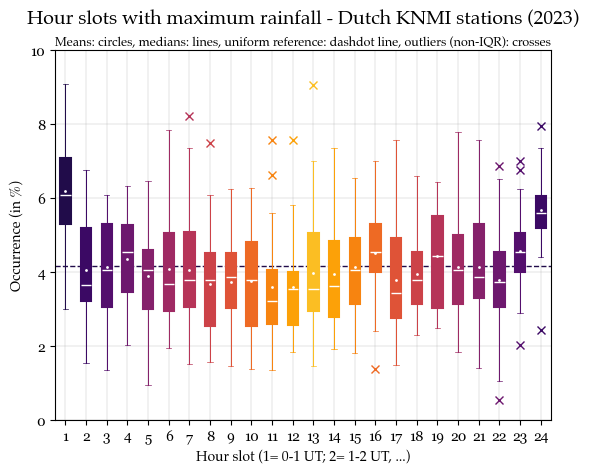

<Figure size 7200x4800 with 0 Axes>

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create boxplot of maximum rainfall occurrence per hour slot
title_txt = f"Hour slots with maximum rainfall - Dutch KNMI stations ({YEAR})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_max_rain_h_slot_pcs.T, 
                                                  title_text=title_txt,
                                                  subtitle_text=subtitle_txt)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

#### Observations

##### Generic
For the year of choice (2023), the general pattern seems to be that the maximum rainfall hour slots are relatively uniformly distributed throughout the day. This can be derived from the relatively modest offsets of the means (circles in each box) compared to the horizontal dotted line that represents a hypothetical perfectly uniform outcome (at 100% / 24 = 4.167%).

The length of the boxes (the thick parts of each boxplot), by definition bounded at the 25th (lower edge) and 75th percentile (upper edge), indicate that the "middle" 50% of the data distribution generally falls within a bandwidth of 1% to 2%. Since the measurement stations in the dataset are spread out throughout The Netherlands, this indicates a relatively limited geographic variability of the timing of maximum rainfall - at least for 2023. 

##### Detailed
A more detailed inspection reveals some more subtle patterns. Except for the boxplots representing hour slots 1 and 4, the first half of the hour slots seem to have slightly lower values compared to the average, with a slight trend further downwards towards the middle of the day (hour slot 13). After a marked peak in hour slot 16 (perhaps indicating summer-time thunder storms) and a decrease immediately after, there seems to be an upward trend again towards hour slot 19, followed by another decreasing trend up to hour slot 22, where hour slots 23 and 24 show clear increases.

The variability of the maximum rainfall occurrence (length of the thick boxes) seems to be slightly more pronounced in the late night and early morning hours, with another variability peak just after midday (hour slots 13 and 14).

Some outliers are marked in the box plots, but their number is relatively small (14 from a total dataset of 24 hour slots x 33 stations = 792 for the year 2023). This might be one-season patterns - we can test this by looking at a longer timespan. We will do this in the following example - stay tuned!

##### Possible explanation of peaks at hour slots 1 and 24
There are two striking peaks that look as if they deviate from the overall signal in the figure: the first and the last hour slots in the dataset (1 and 24). Since these peaks occur exactly at the extreme values (lowest and highest), and similarly show up in later plots, these peaks are likely caused by KNMI's internal measurement conventions. For instance, hour slot 1 may be the default for every new day, and only be overridden if the maximum value in a later hour slot <em>exceeds</em> the value of hour slot 1. This would lead to a slight positive bias for hour slot 1 in the outcome. Similarly, hour slot 24 might be used for non-dry days on which the total precipitation surpassed 0.1 mm, but the individual hour measurements are all rounded to 0.0 mm. In a real-world situation, this would be the moment to contact a KNMI expert to verify whether this is actually the case. 

If the hypothesis just stated were to be true, we could apply additional statistical analysis to correct for this (if a direct correction from the dataset itself would not be feasible). However, for the purpose of this analysis we will keep on using the data "as-is", while just staying mindful of the fact that hour slots 1 and 24 seem to have some degree of (most likely definition-related) upward bias.

##### Notes
The hour slots are marked in UT (Universal Time), which means that for Dutch local winter time, one hour needs to be added to the UT, and two to obtain local summer time. For example: hour slot 14 represents 13-14 UT, which translates to 14-15 CET (Dutch / Central European winter time) and to 15-16 CEST (Dutch / Central European summer time). 

The highest elevation of the Sun on each day (the historical definition of "noon") takes place around 11:40 UT throughout the year in The Netherlands.

### Example 1.2: Rain hour slot pattern for 2001-2020 (as comparison)

#### Another plot
Now that we have looked at a single year of maximum rainfall timing and have drawn out some insights, let's take the opportunity to extend the timeframe to a longer period and see whether similar patterns arise.

Initially I had hoped to make use of the full climatic 30-year reference period of 1991-2020, but some of the hour slot data for the early 90s seemed to be missing. Therefore a 20-year period between 2001 and 2020 was chosen for this example.

We will make the same plot as in the previous example, but now we will request the KNMI data separately for each year (to prevent fetching too much data at once for the service to handle) and glue it together to get our full dataset. In the cell below we make use of a custom helper function from script <code>knmi_meteo_transform.py</code> to do this. 

Subsequently, the boxplots are created using a custom helper function in <code>knmi_meteo_visualize.py</code>.

The stepwise retrieval of the required data may require the cell below to take some 10 - 30 seconds to complete.

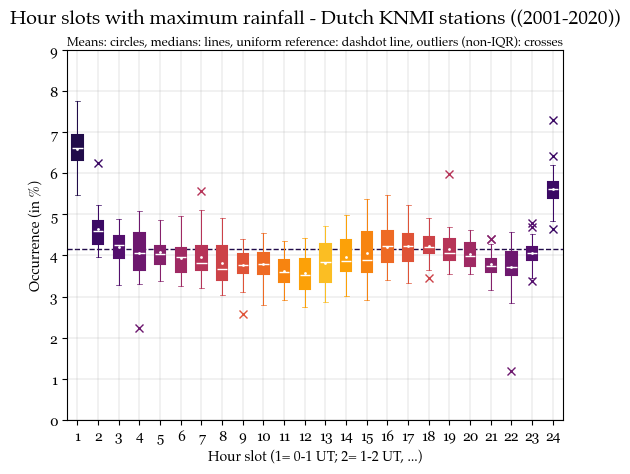

<Figure size 7200x4800 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

# Fetch KNMI data year by year to prevent service overflow
df_h_slots = knmi_meteo_transform.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END)

# Create boxplot of maximum rainfall occurrence per hour slot
title_txt = f"Hour slots with maximum rainfall - Dutch KNMI stations ({YEAR_START}-{YEAR_END})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_slots, 
                                                  title_text=title_txt,
                                                  subtitle_text=subtitle_txt)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

#### Observations

##### Generic
The long-term data leads to a much clearer picture and less "noise" in the data compared to looking at only a single year. Although we now use a lot more data (20x more), the variability (length of the thick parts of the boxplots) within the plot is greatly reduced, enabling us to draw insights with additional confidence. 

Again we can derive that the overall distribution of hour slots is relatively uniform when it comes to the typical timing of maximum rainfall. Except for hour slots 1 and 24, all means and medians are within 0.5% of the dotted "perfect uniformity" line.

Also notable are the relative "valleys" in the late morning (hour slots 4 - 10), early afternoon (hour slots 11 - 15) and in the middle-late evening hours (hour slots 19 - 22). At the same time, there are relative peaks in the night (hour slots 24 - 3) and in the late afternoon (hour slots 16 - 18).

The variability has reduced while the time frame is now substantially larger. This strengthens the idea that the maximum rainfall timing is relatively similar throughout The Netherlands, geographically speaking.

##### Detailed
Again we see the likely upward bias for hour slots 1 and 24 as mentioned in the earlier example. The fact that it shows up more markedly in the long-term dataset strengthens the suspicion that a definition-related issue lies at the root of this.

The number of outliers is still relatively low, as in our one-year example (14 out of 792; 1.77% of the data). In this longer-term case, the outliers are likely to be caused by local effects that deviate from the general rainfall pattern for The Netherlands. We can say this with more certainty now because of the increased longevity of the dataset (20 years, instead of one in the previous example).

##### Conclusion
The maximum rainfall intensity for rainy days in The Netherlands in the last ~20 years is distributed relatively uniformly throughout the day and throughout the country. Mornings and late evenings show slightly less inclination for having maximum rainfall. In contrast, midnight-early morning and late afternoons tend to have a relatively slightly higher probability of maximum rainfall occurrence.

##### Notes
As is generally true for many datasets, using a longer timeframe for the data leads to less "noisy" signals in the data. Because of this, we can derive conclusions considerably more comfortably. 

The same idea holds for datasets when applying Machine Learning. Although useful insights can definitely be distilled from short-term datasets, more long-term and complete datasets will allow you (and any Machine Learning model you are trying to train) to pick up on many more subtle and generalizable patterns, generally leading to better results.

### Example 1.3: Maximum temperature hour slot pattern (2001-2020)

#### Introduction
In this example we will focus on the temporal pattern of the maximum temperature for The Netherlands. Contrary to the relatively uniformly distributed maximum rainfall, this parameter is expected to have a non-uniform result with peaks in the early afternoon. 

We take a relatively long (20-year) timeframe to reduce one-seasonal effects.

Besides changing the parameter of interest, the recipe for the code is almost the same as in the previous example:

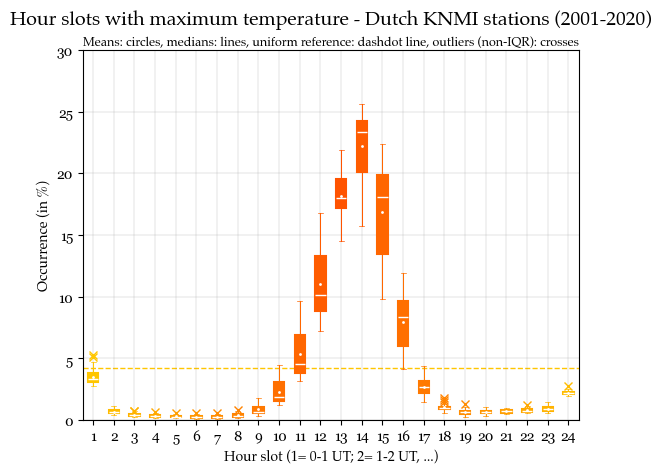

<Figure size 7200x4800 with 0 Axes>

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

df_h_slots = knmi_meteo_transform.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END,
    param_col="max_temp", hourslot_col="hour_slot_max_temp")

title_txt = f"Hour slots with maximum temperature - Dutch KNMI stations ({YEAR_START}-{YEAR_END})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_slots, title_text=title_txt,
                                                  subtitle_text=subtitle_txt,
                                                  cmap_name_a="autumn_r", cmap_name_b="autumn_r",
                                                  c_min=0.225, c_max=0.675)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

#### Observations
In this case the outcome distribution is far from uniform. When taking into account that the start of the Dutch midday (peak solar elevation) falls at the end of hour slot 11 (at around 11:40 UT), there is generally a two- to four-hour delay before reaching the maximum temperature mid- to late afternoon. The maximum temperature is reached in hour slot 14 (representing 14-15 local winter time, and 15-16 local summer time) during 20% to 25% of the days during the 20-year observation period.

A handul of outliers is present in the nightly values. However, the relative distance to the remaining parts of the boxplots is generally sufficiently small to be explained by the relative tight values of the interquartile range. There are probably some minor local effects at play in these cases as well.

Once again the peaks at hour slots 1 and 24 (compared to their neighboring hour slots) are notable, most likely due to slight definition imbalances as mentioned and explained in more detail in the first example of this section.

### Example 1.4: Maximum average wind speed hour slot pattern (2001-2020)

#### Introduction
In this example we will zoom in on the temporal pattern of the maximum average wind speed for The Netherlands.

Again we take a relatively long (20-year) timeframe to reduce one-seasonal effects.

Besides changing the parameter of interest, the recipe for the code is almost the same as in the previous examples:

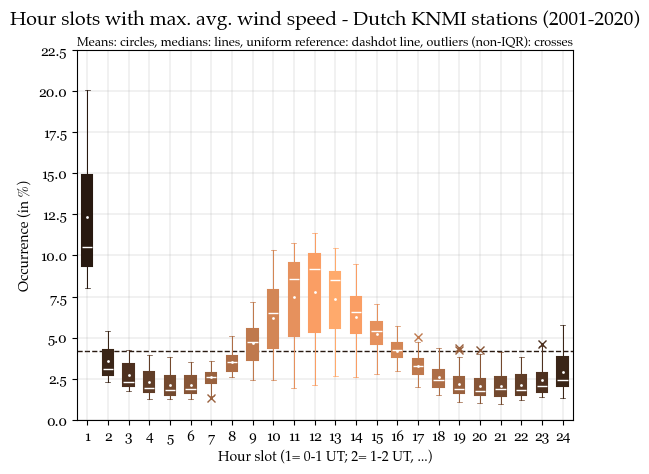

<Figure size 7200x4800 with 0 Axes>

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

df_h_slots = knmi_meteo_transform.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END,
    param_col="max_hour_avg_wind_speed",
    hourslot_col="hour_slot_max_avg_wind_speed")

title_txt = f"Hour slots with max. avg. wind speed - Dutch KNMI stations ({YEAR_START}-{YEAR_END})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_slots, title_text=title_txt,
                                                   subtitle_text=subtitle_txt,
                                                   cmap_name_a="copper", cmap_name_b="copper")

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

#### Observations
In this case the outcome distribution is also non-uniform. Interesting is that the main pattern in the plot clearly shows that the maximum average wind speed tends to occur more frequently around the late morning, midday and the early afternoon (hour slots 9 - 14). At the same time, the largest "valleys" occur in the early morning and late evening. Apparently the pressure gradients (the driving mechanism for air to flow) are most pronounced in the one to two-hour timeframe after the Sun has reached the highest point (around 11:40 UT).

A handul of outliers is present. However, the relative distance to the remaining parts of the boxplots is generally sufficiently small to be explained by the relative tight values of the interquartile range. There are probably some minor local effects at play in these cases as well.

This time only a clear peak at hour slot 1 surfaces, while the value for hour slot 24 does not look out of the ordinary here. It might be the case that taking a higher threshold for marking days with "too-low" wind speeds could reduce the upward bias in that peak.

## Section 2: Parameter-based spatial patterns (Kriging)

### Introduction
In this section we will move away from the colorful boxplots from Section 1. Instead we will infer spatial insights by producing some colorful maps based on the KNMI data available to us.

### Kriging
The observations from the KNMI meteo stations can be spread out to a wider geographic region using a technique called "Kriging". This is a geospatial interpolation technique that takes the underlying noise that is present in the data into account. It was first used in the field of mining to better predict where to find gold from a limited set of observations. Nowadays it has evolved into a relatively common approach throughout e.g. geoscience, hydrology and Data Science. 

KNMI uses a strongly similar method to produce their daily published maps of e.g. temperature, wind or the actual drought conditions. And in this section we will use Kriging to find our own "gems" from the KNMI dataset! 

The method of filling a 2D map of points using the $(x, y)$ locations of measurement sites is called "Ordinary Kriging". This is the specific technique that we are going to use to produce our maps.

For more information [also see this Wikipedia article on Kriging](https://en.wikipedia.org/wiki/Kriging).

### Example 2.1: Spatial distribution of Dutch sunshine in a given year

#### Sunshine
Admittedly a scarce resource in this region at times, but nevertheless: in this example we will dive into the geographic variability of sunshine throughout The Netherlands. 

From this analysis we can start answering questions such as:
- What are the best regions in The Netherlands for placing solar panels?
- What energy yield can I expect from my Dutch, sun-facing roofs?
- Where should I move to if I want to relocate within The Netherlands, while maximizing my potential sun exposure (Caribbean excluded)?

We will look at a full single year. However, and as always, feel free to also experiment with longer periods, different years and/or seasons.

#### Obtain the raw dataset from the KNMI web service

Let's start by loading the Daily global irradiance (Q), in $J/cm^{2}$, from the KNMI web service. This parameter is available in the day-based dataset which we will import below.

In this example, we set 2023 as our year of interest. Again, feel free to change this to another year if desired.

In [31]:
YEAR = 2023

# Set start and end dates (inclusive) for data retrieval
start_date = datetime.date(YEAR, 1, 1)
end_date = datetime.date(YEAR, 12, 31)

# Optional: uncomment below to make end_date exclusive
# end_date -= datetime.timedelta(days=1)

In [32]:
# Get irradiance data from KNMI web script service
df_irrad_raw = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                  meteo_params_list=["Q"],
                                                  start_date=start_date,
                                                  end_date=end_date)

In [33]:
# Show the result
df_irrad_raw

,STN,YYYYMMDD,Q
0,209,20230101,NaN
1,209,20230102,NaN
2,209,20230103,NaN
3,209,20230104,NaN
4,209,20230105,NaN
...,...,...,...
17150,391,20231227,124.0
17151,391,20231228,182.0
17152,391,20231229,98.0
17153,391,20231230,178.0


#### Clean (transform) dataset
We can improve the readability of the dataset by applying some preset transformations on the "raw" dataset we just ingested. We use the same recipe as in the earlier examples.

In [34]:
# Apply transformations to clean the raw dataset
df_irrad = knmi_meteo_transform.transform_param_values(df_irrad_raw)

In [35]:
# Show the result
df_irrad

,station_code,date,global_irradiance
0,209,2023-01-01,NaN
1,209,2023-01-02,NaN
2,209,2023-01-03,NaN
3,209,2023-01-04,NaN
4,209,2023-01-05,NaN
...,...,...,...
17150,391,2023-12-27,124.0
17151,391,2023-12-28,182.0
17152,391,2023-12-29,98.0
17153,391,2023-12-30,178.0


#### Pivoting our way to success

At this point we are left with a "long" format DataFrame, where each row in the DataFrame represents a single hour slot value for a given day and station. 

However, our desired DataFrame, should have the day as the index, the station as the column, and the hour slot as value ("wide" format).

In order to reformat the DataFrame as desired, we apply a pivot function in the cells below.

In [36]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_irrad_pivot = (df_irrad
                  .pivot(index="date",
                         columns="station_code"))

# Flatten pivot table to single index
df_irrad_pivot.columns = (df_irrad_pivot.columns
                          .get_level_values(1))


In [37]:
# Show the result
df_irrad_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,221.0,NaN,222.0,218.0,NaN,NaN,196.0,224.0,203.0,...,NaN,182.0,203.0,151.0,184.0,165.0,177.0,212.0,145.0,116.0
2023-01-02,NaN,155.0,NaN,169.0,143.0,NaN,NaN,146.0,177.0,148.0,...,NaN,147.0,151.0,128.0,139.0,147.0,135.0,152.0,133.0,149.0
2023-01-03,NaN,177.0,NaN,125.0,129.0,NaN,NaN,123.0,128.0,121.0,...,NaN,166.0,140.0,147.0,140.0,140.0,148.0,225.0,251.0,157.0
2023-01-04,NaN,129.0,NaN,163.0,123.0,NaN,NaN,146.0,152.0,128.0,...,NaN,137.0,135.0,79.0,116.0,79.0,89.0,91.0,66.0,72.0
2023-01-05,NaN,249.0,NaN,200.0,215.0,NaN,NaN,207.0,237.0,210.0,...,NaN,222.0,239.0,222.0,284.0,209.0,230.0,247.0,174.0,206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,58.0,NaN,42.0,58.0,NaN,NaN,47.0,49.0,57.0,...,NaN,82.0,72.0,122.0,92.0,132.0,110.0,162.0,170.0,124.0
2023-12-28,NaN,164.0,NaN,156.0,147.0,NaN,NaN,174.0,135.0,199.0,...,NaN,159.0,195.0,240.0,209.0,187.0,188.0,225.0,289.0,182.0
2023-12-29,NaN,162.0,NaN,154.0,177.0,NaN,NaN,156.0,210.0,148.0,...,NaN,175.0,176.0,145.0,154.0,108.0,126.0,106.0,133.0,98.0


#### Check missing data values per station

In [38]:
# Show counts of % of missing data for the stations
(df_irrad_pivot.isnull().mean() * 100).value_counts()

0.0      32
100.0    15
Name: count, dtype: int64

#### Remove stations with > 1% missing data

Great! The irradiance data is either fully available or fully absent per station for our sample year (2023). This underlines once more how good the quality of the KNMI dataset actually is. 

However, let's still put a filter on our DataFrame to always only keep stations having less than 1% of missing data, just to be safe. 

Note that we set the requirement for data completion much stricter here than in the previous hour slot-based section (10% missing data allowed there). This is because now our data is highly seasonally variable, meaning that the impact of just a few missing values (especially in summer) can already be substantial. Also, we are now aiming to highlight (potentially subtle) spatial variations as fairly and completely as possible, compared to working with averages over all stations in the previous section. 

#### Key take-away
Always keep in mind to align the quality of the data with the problem you are trying to solve, and to assess whether it is possible to reach a satisfactory degree of quality in the first place. Sometimes the conclusion will be that it is not possible to solve a certain business problem adequately with the quality of the data at hand. Best to find this out as early as possible when working on a problem!

In [39]:
# Only keep stations with <1% of missing data days
filter_cond = df_irrad_pivot.isnull().mean() < .01
df_irrad_sel = df_irrad_pivot.loc[:, filter_cond]

In [40]:
# Show shape of remaining dataset
print(f"Rows (periods): {df_irrad_sel.shape[0]} | "
      f"Cols (stations): {df_irrad_sel.shape[1]}")

Rows (periods): 365 | Cols (stations): 32


#### Convert sunshine to kWh per surface area; sum daily observations to totals

The standard reporting format for annual sunshine (solar energy) is $kWh/m^{2}$. We apply a conversion factor of $1/360$ to transform the output data from its inital unit of measurement, $J/cm^{2}$. Furthermore, we sum up the daily values per station to get our desired total year-based numbers.

In [41]:
# Convert J/cm2 to kWh/m2 and sum to totals
conv_to_kwh_m2 = 1 / 360
df_solar = (df_irrad_sel.sum() 
            * conv_to_kwh_m2).round(1)

# Convert pd.Series to pd.DataFrame
df_solar = (df_solar.to_frame(name="global_irrad")
            .reset_index())

In [42]:
# Show a few results (in kWh/m2)
df_solar.head()

,station_code,global_irrad
0,215,1144.6
1,235,1145.3
2,240,1125.8
3,249,1123.0
4,251,1157.8


#### Merge station-based results with metadata for location pinpointing

In order to link the results we just obtained to their location on the map, we will load the station metadata as a dataset to merge on in the next steps:

In [43]:
# Get cleaned station (meta)data for adding lon, lat-data
df_stns = knmi_meteo_ingest.knmi_load_meteo_stations()
df_stns = knmi_meteo_transform.transform_stations(df_stns)

df_stns.head()

,station_code,longitude,latitude,altitude,location_name
0,209,4.518,52.465,0.0,IJmond
1,210,4.430,52.171,-0.2,Valkenburg Zh
2,215,4.437,52.141,-1.1,Voorschoten
3,225,4.555,52.463,4.4,IJmuiden
4,235,4.781,52.928,1.2,De Kooy


We apply the merge of results with stations locations using a "left join" on <code>station_code</code>, since we want to keep all results and get a NaN-location for a result (and not a drop of the result) in case a matching location is not found. This should not happen in our KNMI dataset, however.

In [44]:
# Merge station location (meta)data to our results
df_solar_stns = df_solar.merge(df_stns, how="left", 
                               on="station_code")
df_solar_stns.tail()

,station_code,global_irrad,longitude,latitude,altitude,location_name
27,370,1119.5,5.377,51.451,22.6,Eindhoven
28,375,1121.5,5.707,51.659,22.0,Volkel
29,377,1127.5,5.763,51.198,30.0,Ell
30,380,1119.9,5.762,50.906,114.3,Maastricht
31,391,1093.9,6.197,51.498,19.5,Arcen


#### Reformat locations and values to NumPy arrays
As a last preparation step before we set up our map visualization, we convert the $(x, y)$ locations of the stations and the output values (in this case: <code>global_irrad</code>) from the DataFrame to NumPy arrays:

In [45]:
# Convert columns of interest to NumPy arrays
stations_x = df_solar_stns["longitude"].to_numpy()
stations_y = df_solar_stns["latitude"].to_numpy()
values = df_solar_stns["global_irrad"].to_numpy()

print(f"Longitude range (deg): {stations_x.min()} - {stations_x.max()}; {stations_x.shape[0]} values")
print(f"Latitude range (deg): {stations_y.min()} - {stations_y.max()}; {stations_y.shape[0]} values")
print(f"Value range (kWh/m2): {values.min()} - {values.max()}; {values.shape[0]} values")

Longitude range (deg): 3.596 - 7.15; 32 values
Latitude range (deg): 50.906 - 53.413; 32 values
Value range (kWh/m2): 1079.7 - 1192.3; 32 values


#### Creating the map
We will create a solar energy / sunshine map for The Netherlands for the period of interest using a helper function from script <code>knmi_meteo_visualize.py</code>. In this script, the $(x, y)$ locations of the stations and the observed values $(z)$ are required inputs.

By default, the script interpolates the measurements to a grid of 500 x 500 cells (<code>grid_dim_xy</code>), which may take some 10 to 30 seconds to complete. In case you desire a faster result (although this will lead to a visually slightly less appealing map), change this to e.g. 100 x 100 cells by setting <code>grid_dim_xy</code> to 100. 

It is also possible to change the colormap presented on the map. You can also change the marker look (size, style and color) of the observation locations.

That being said - let's present our sunshine map using the code in the cell below:

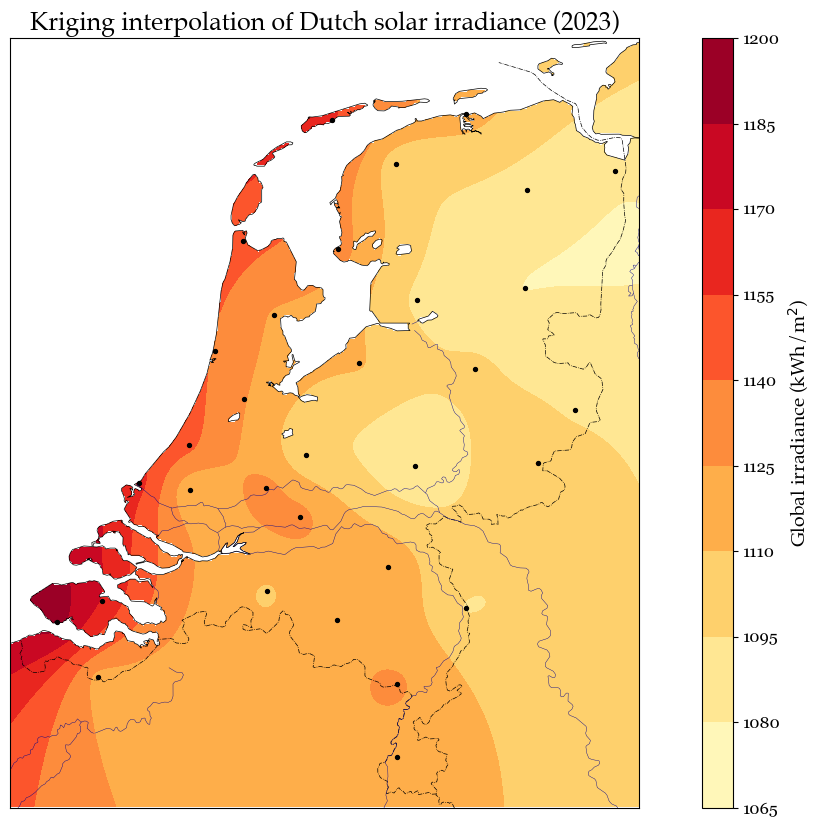

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define figure dimensions
fig = plt.figure(figsize=(15, 10))

ax = knmi_meteo_visualize.ordinary_kriging_nl_plot(
    stations_x, stations_y, values,
    plot_title = f"Kriging interpolation of Dutch solar irradiance ({YEAR})",
    val_label = "Global irradiance (kWh/m$^{2}$)")

fig.axes.append(ax)

# Show the plot
plt.show()

#### Observations
Overall the total irradiance over the year of interest (2023) shows clear spatial variation. The values range from 1065 to 1200 $kWh/m^{2}, indicating a 10-15 % variability between the most and least sunny zones. 

The sunniest zones were the area around the province of Zeeland and the northwestern Wadden Islands (specifically Texel, Vlieland and Terschelling), followed by the western coastal zones of the provinces of North and South Holland. The southern section of the country (Brabant and Limburg provinces) scored relatively average in terms of sunshine. The Veluwe zone in Gelderland, the (north)eastern portion of the country, and specifically east-Drenthe, were the least sunny regions in our year of interest (2023).

In general: the closer to the coast, the sunnier, and the closer to Zeeland, the sunnier. So, those of us owning solar panels and the sun-friendly amongst us would be most content to reside in the NW zone of the country or in the province of Zeeland.

#### Notes
- This map shows global irradiance on a flat (horizontal) plane; solar panels are usually inclined - this will lead to slightly different energy outcomes while the regional differences will still be similar. This factor should be corrected for when doing solar energy (PV) yield modeling. The potential impact of local shading should be considered as well in this case.
- Because we only make use of the KNMI weather station observations (around 30 to 35), small-scale local effects will not show up on the map. Although the local effects are expected to be limited in the case of irradiance summed over a year, this is something to keep in mind.

### Example 2.2: Spatial distribution of Dutch rainfall in a given year

#### Introduction
Let's work through another similar example, but now for the spatial distribution of rainfall throughout The Netherlands for a given year.

#### Obtain the raw dataset from the KNMI web service

Let's start by loading the daily precipitation (RH), in $mm$, from the KNMI web service. This parameter is available in the day-based dataset which we will import below.

In this example, we set 2023 as our year of interest. Again, feel free to change this to another year if desired.

In [47]:
YEAR = 2023

# Set start and end dates (inclusive) for data retrieval
start_date = datetime.date(YEAR, 1, 1)
end_date = datetime.date(YEAR, 12, 31)

# Optional: uncomment below to make end_date exclusive
# end_date -= datetime.timedelta(days=1)

In [48]:
# Get precipitation data from KNMI web script service
df_precip_raw = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                   meteo_params_list=["RH"],
                                                   start_date=start_date,
                                                   end_date=end_date)

In [49]:
# Show the result
df_precip_raw

,STN,YYYYMMDD,RH
0,209,20230101,NaN
1,209,20230102,NaN
2,209,20230103,NaN
3,209,20230104,NaN
4,209,20230105,NaN
...,...,...,...
17150,391,20231227,33.0
17151,391,20231228,0.0
17152,391,20231229,93.0
17153,391,20231230,0.0


#### Clean (transform) dataset
We can improve the readability of the dataset by applying some preset transformations on the "raw" dataset we just ingested. We use the same recipe as in the earlier examples.

In [50]:
# Apply transformations to clean the raw dataset
df_precip = knmi_meteo_transform.transform_param_values(df_precip_raw)

In [51]:
# Show the result
df_precip

,station_code,date,rain_sum
0,209,2023-01-01,NaN
1,209,2023-01-02,NaN
2,209,2023-01-03,NaN
3,209,2023-01-04,NaN
4,209,2023-01-05,NaN
...,...,...,...
17150,391,2023-12-27,3.3
17151,391,2023-12-28,0.0
17152,391,2023-12-29,9.3
17153,391,2023-12-30,0.0


#### Pivot the data

At this point we are left with a "long" format DataFrame, where each row in the DataFrame represents a single hour slot value for a given day and station. 

However, our desired DataFrame, should have the day as the index, the station as the column, and the hour slot as value ("wide" format).

In order to reformat the DataFrame as desired, we apply a pivot function in the cells below.

In [52]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_precip_pivot = (df_precip
                  .pivot(index="date",
                         columns="station_code"))

# Flatten pivot table to single index
df_precip_pivot.columns = (df_precip_pivot.columns
                          .get_level_values(1))

In [53]:
df_precip_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,6.000,NaN,6.300,5.700,NaN,NaN,4.400,5.5,7.2,...,NaN,3.700,3.500,3.4,4.100,4.4,7.6,2.500,2.900,3.5
2023-01-02,NaN,2.000,NaN,2.900,3.400,NaN,NaN,3.600,1.7,2.9,...,NaN,2.200,3.900,3.0,3.500,3.9,3.2,7.200,9.300,4.3
2023-01-03,NaN,3.600,NaN,2.100,1.900,NaN,NaN,1.300,2.5,2.7,...,NaN,5.400,1.500,2.0,0.800,0.6,0.5,0.200,0.025,0.1
2023-01-04,NaN,8.200,NaN,18.100,10.500,NaN,NaN,12.900,14.1,6.3,...,NaN,10.900,11.000,4.8,8.700,5.5,6.2,4.900,2.700,7.8
2023-01-05,NaN,0.500,NaN,0.200,0.900,NaN,NaN,0.700,0.6,0.3,...,NaN,0.800,0.300,0.6,1.100,0.9,0.6,0.300,2.400,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,3.700,NaN,2.600,2.200,NaN,NaN,3.400,3.4,2.7,...,NaN,4.100,4.000,3.7,5.000,3.7,4.1,1.300,0.300,3.3
2023-12-28,NaN,3.700,NaN,1.500,0.500,NaN,NaN,0.025,1.0,0.1,...,NaN,1.100,0.025,0.0,0.025,0.0,0.0,0.000,0.000,0.0
2023-12-29,NaN,4.200,NaN,0.025,12.100,NaN,NaN,3.400,1.3,1.9,...,NaN,1.800,5.700,4.4,13.600,15.3,4.4,7.800,8.200,9.3


#### Check missing data values per station

In [54]:
# Show counts of % of missing data for the stations
(df_precip_pivot.isnull().mean() * 100).value_counts()

0.0      33
100.0    14
Name: count, dtype: int64

#### Remove stations with > 1% missing data

Great! The precipitation data is either fully available or fully absent per station for our sample year (2023). This underlines once more how good the quality of the KNMI dataset actually is. 

However, let's still put a filter on our DataFrame to always only keep stations having less than a certain percentage of missing data, just to be safe. As we are once again performing a summation of a highly variable parameter, we set this threshold relatively strictly at 1%.

In [55]:
# Only keep stations with <1% of missing data days
filter_cond = df_precip_pivot.isnull().mean() < .01
df_precip_sel = df_precip_pivot.loc[:, filter_cond]

In [56]:
# Show shape of remaining dataset
print(f"Rows (periods): {df_precip_sel.shape[0]} | "
      f"Cols (stations): {df_precip_sel.shape[1]}")

Rows (periods): 365 | Cols (stations): 33


#### Aggregate daily values to full period
Since the data is already provided in $mm$, a unit conversion step is not required in this example. We can aggregate the daily precipitation values for each station to full-period (in this case: yearly) totals in one go:

In [57]:
# Sum rain values to totals
df_rain = df_precip_sel.sum().round(1)

# Convert pd.Series to pd.DataFrame
df_rain = (df_rain.to_frame(name="precip")
            .reset_index())

In [58]:
df_rain.tail()

,station_code,precip
28,370,1191.7
29,375,1030.2
30,377,978.1
31,380,982.0
32,391,1091.8


#### Merge station-based results with metadata for location pinpointing

In order to link the results we just obtained to their location on the map, we will load the station metadata as a dataset to merge on in the next steps:

In [59]:
# Get cleaned station (meta)data for adding lon, lat-data
df_stns = knmi_meteo_ingest.knmi_load_meteo_stations()
df_stns = knmi_meteo_transform.transform_stations(df_stns)

df_stns.head()

,station_code,longitude,latitude,altitude,location_name
0,209,4.518,52.465,0.0,IJmond
1,210,4.430,52.171,-0.2,Valkenburg Zh
2,215,4.437,52.141,-1.1,Voorschoten
3,225,4.555,52.463,4.4,IJmuiden
4,235,4.781,52.928,1.2,De Kooy


We apply the merge of results with stations locations using a "left join" on <code>station_code</code>, since we want to keep all results and get a NaN-location for a result (and not a drop of the result) in case a matching location is not found. This should not happen in our KNMI dataset, however.

In [60]:
# Merge station location (meta)data to our results
df_rain_stns = df_rain.merge(df_stns, how="left", 
                               on="station_code")
df_rain_stns.tail()

,station_code,precip,longitude,latitude,altitude,location_name
28,370,1191.7,5.377,51.451,22.6,Eindhoven
29,375,1030.2,5.707,51.659,22.0,Volkel
30,377,978.1,5.763,51.198,30.0,Ell
31,380,982.0,5.762,50.906,114.3,Maastricht
32,391,1091.8,6.197,51.498,19.5,Arcen


#### Reformat locations and values to NumPy arrays
As a last preparation step before we set up our map visualization, we convert the $(x, y)$ locations of the stations and the output values (in this case: <code>precip</code>) from the DataFrame to NumPy arrays:

In [61]:
# Convert columns of interest to NumPy arrays
stations_x = df_rain_stns["longitude"].to_numpy()
stations_y = df_rain_stns["latitude"].to_numpy()
values = df_rain_stns["precip"].to_numpy()

print(f"Longitude range (deg): {stations_x.min()} - {stations_x.max()}; {stations_x.shape[0]} values")
print(f"Latitude range (deg): {stations_y.min()} - {stations_y.max()}; {stations_y.shape[0]} values")
print(f"Value range (mm): {values.min()} - {values.max()}; {values.shape[0]} values")

Longitude range (deg): 3.596 - 7.15; 33 values
Latitude range (deg): 50.906 - 53.413; 33 values
Value range (mm): 883.0 - 1273.4; 33 values


#### Creating the map
We will create a precipitation map for The Netherlands for the period of interest using a helper function from script <code>knmi_meteo_visualize.py</code>. In this script, the $(x, y)$ locations of the stations and the observed values $(z)$ are required inputs.

By default, the script interpolates the measurements to a grid of 500 x 500 cells (<code>grid_dim_xy</code>), which may take some 10 to 30 seconds to complete. In case you desire a faster result (although this will lead to a visually slightly less appealing map), change this to e.g. 100 x 100 cells by setting <code>grid_dim_xy</code> to 100. 

For convergence purposes, the <code>variogram_model</code> is now set to "spherical". This is due to the nature of the spatial distribution of rainfall, which is relatively "patchy". Note the contrast with our earlier choice of "linear" for the spatially much more smoothly distributed (annual) irradiance.

It is also possible to change the colormap presented on the map. You can also change the marker look (size, style and color) of the observation locations.

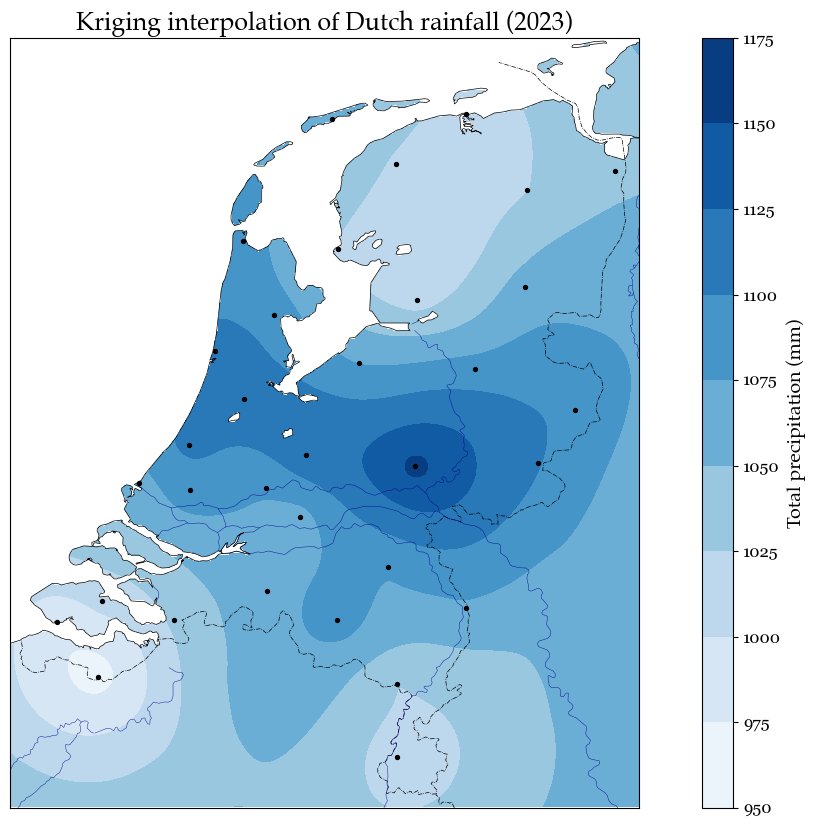

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define figure dimensions
fig = plt.figure(figsize=(15, 10))

ax = knmi_meteo_visualize.ordinary_kriging_nl_plot(
    stations_x, stations_y, values,
    cmap = "Blues",
    variogram_model = "spherical",
    plot_title = f"Kriging interpolation of Dutch rainfall ({YEAR})",
    val_label = "Total precipitation (mm)")

fig.axes.append(ax)

# Show the plot
plt.show()

#### Observations
The local effects are relatively strong here, since the plot requires a relatively high degree of local "cells" of high and low values to fit the observations to the interpolated spread of values in the map. 

The total variability in the map is around 20% (950 to 1175 mm). For the year of interest the driest regions are South Zeeland, South Limburg, and the north region (central Friesland and West part of Groningen province). Meanwhile the area around the Veluwe forestal zone in Gelderland is markedly wettest, with the entire middle of The Netherlands up to the coastline in the mid-west trailing just behind.

#### Notes
For a more spatially fine-grained view, you can use the KNMI-monitored precipitation stations instead of the meteo stations used in this analysis. More than 300 of those stations are located throughout The Netherlands, compared to around only 35 meteo stations. However, keep in mind that those datasets will require more rigid data cleaning. In short, be careful to apply more extensive data quality checks in that case.

### Example 2.3: Spatial distribution of Dutch average temperatures in a given year

#### Introduction
Let's work through another similar example, but now for the spatial distribution of average temperatures throughout The Netherlands for a given year.

#### Obtain the raw dataset from the KNMI web service

Let's start by loading the daily average temperature (TG), in $°C$, from the KNMI web service. This parameter is available in the day-based dataset which we will import below.

In this example, we set 2023 as our year of interest. Again, feel free to change this to another year if desired.

In [63]:
YEAR = 2023

# Set start and end dates (inclusive) for data retrieval
start_date = datetime.date(YEAR, 1, 1)
end_date = datetime.date(YEAR, 12, 31)

# Optional: uncomment below to make end_date exclusive
# end_date -= datetime.timedelta(days=1)

In [64]:
# Get temperature data from KNMI web script service
df_temp_raw = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                 meteo_params_list=["TG"],
                                                 start_date=start_date,
                                                 end_date=end_date)

In [65]:
# Show the result
df_temp_raw

,STN,YYYYMMDD,TG
0,209,20230101,NaN
1,209,20230102,NaN
2,209,20230103,NaN
3,209,20230104,NaN
4,209,20230105,NaN
...,...,...,...
17150,391,20231227,74.0
17151,391,20231228,108.0
17152,391,20231229,100.0
17153,391,20231230,88.0


#### Clean (transform) dataset
We can improve the readability of the dataset by applying some preset transformations on the "raw" dataset we just ingested. We use the same recipe as in the earlier examples.

In [66]:
# Apply transformations to clean the raw dataset
df_temp = knmi_meteo_transform.transform_param_values(df_temp_raw)

In [67]:
# Show the result
df_temp

,station_code,date,day_avg_temp
0,209,2023-01-01,NaN
1,209,2023-01-02,NaN
2,209,2023-01-03,NaN
3,209,2023-01-04,NaN
4,209,2023-01-05,NaN
...,...,...,...
17150,391,2023-12-27,7.4
17151,391,2023-12-28,10.8
17152,391,2023-12-29,10.0
17153,391,2023-12-30,8.8


#### Pivot the data

At this point we are left with a "long" format DataFrame, where each row in the DataFrame represents a single hour slot value for a given day and station. 

However, our desired DataFrame, should have the day as the index, the station as the column, and the hour slot as value ("wide" format).

In order to reformat the DataFrame as desired, we apply a pivot function in the cells below.

In [68]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_temp_pivot = (df_temp
                  .pivot(index="date",
                         columns="station_code"))

# Flatten pivot table to single index
df_temp_pivot.columns = (df_temp_pivot.columns
                         .get_level_values(1))

In [69]:
# Show the result
df_temp_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,12.0,NaN,10.3,11.9,9.9,NaN,11.3,9.4,11.0,...,NaN,12.0,11.9,12.4,12.1,12.6,12.5,13.2,12.9,13.1
2023-01-02,NaN,7.8,NaN,7.7,8.0,7.5,NaN,7.4,7.1,8.3,...,NaN,7.9,8.2,9.2,8.8,9.3,9.5,9.7,9.7,9.8
2023-01-03,NaN,6.3,NaN,6.4,6.0,6.9,NaN,5.7,6.0,7.3,...,NaN,6.9,6.5,6.6,6.6,6.7,6.5,6.8,7.2,6.8
2023-01-04,NaN,11.7,NaN,10.6,11.7,10.5,NaN,11.2,10.1,10.3,...,NaN,11.6,11.5,11.7,11.5,11.4,11.4,11.4,10.8,11.2
2023-01-05,NaN,10.5,NaN,9.8,10.5,9.8,NaN,10.2,9.3,9.7,...,NaN,10.8,10.6,10.7,10.4,10.6,10.6,10.8,10.4,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,7.8,NaN,7.2,7.4,7.0,NaN,7.2,6.3,7.6,...,NaN,8.2,7.6,8.1,7.5,8.0,7.4,7.8,8.2,7.4
2023-12-28,NaN,10.7,NaN,10.5,10.7,10.5,NaN,11.0,9.8,10.4,...,NaN,10.6,10.5,11.0,10.8,10.9,10.7,10.7,9.9,10.8
2023-12-29,NaN,9.8,NaN,9.5,9.5,9.2,NaN,9.3,8.6,9.5,...,NaN,9.9,9.5,10.1,9.7,9.9,9.8,9.9,9.4,10.0


#### Check missing data values per station

In [70]:
# Show counts of % of missing data for the stations
(df_temp_pivot.isnull().mean() * 100).value_counts()

0.0      34
100.0    13
Name: count, dtype: int64

#### Remove stations with > 5% missing data

Great! The temperature data is, again, either fully available or fully absent per station for our sample year (2023). This underlines again how good the quality of the KNMI dataset is. 

However, let's still put a filter on our DataFrame to always only keep stations having less than a certain percentage of missing data, just to be safe. As we are now performing an averaging instead of a summation, we set this threshold slighly less strictly, at 5%.

In [71]:
# Only keep stations with <5% of missing data days
filter_cond = df_temp_pivot.isnull().mean() < .05
df_temp_sel = df_temp_pivot.loc[:, filter_cond]

In [72]:
# Show shape of remaining dataset
print(f"Rows (periods): {df_temp_sel.shape[0]} | "
      f"Cols (stations): {df_temp_sel.shape[1]}")

Rows (periods): 365 | Cols (stations): 34


#### Aggregate daily values to full period
Since the data is already provided in $°C$, a unit conversion step is not required in this example. Therefore we can aggregate the daily average temperature values for each station to full-period (in this case: yearly) totals in one go:

In [73]:
# Average temperature values to totals
df_avgtemp = df_temp_sel.mean().round(2)

# Convert pd.Series to pd.DataFrame
df_avgtemp = (df_avgtemp.to_frame(name="avg_temp")
              .reset_index())

In [74]:
df_avgtemp.tail()

,station_code,avg_temp
29,370,12.09
30,375,11.92
31,377,12.01
32,380,11.92
33,391,12.03


#### Merge station-based results with metadata for location pinpointing

In order to link the results we just obtained to their location on the map, we will load the station metadata as a dataset to merge on in the next steps:

In [75]:
# Get cleaned station (meta)data for adding lon, lat-data
df_stns = knmi_meteo_ingest.knmi_load_meteo_stations()
df_stns = knmi_meteo_transform.transform_stations(df_stns)

df_stns.head()

,station_code,longitude,latitude,altitude,location_name
0,209,4.518,52.465,0.0,IJmond
1,210,4.430,52.171,-0.2,Valkenburg Zh
2,215,4.437,52.141,-1.1,Voorschoten
3,225,4.555,52.463,4.4,IJmuiden
4,235,4.781,52.928,1.2,De Kooy


We apply the merge of results with stations locations using a "left join" on <code>station_code</code>, since we want to keep all results and get a NaN-location for a result (and not a drop of the result) in case a matching location is not found. This should not happen in our KNMI dataset, however.

In [76]:
# Merge station location (meta)data to our results
df_temp_stns = df_avgtemp.merge(df_stns, how="left", 
                                on="station_code")
df_temp_stns.tail()

,station_code,avg_temp,longitude,latitude,altitude,location_name
29,370,12.09,5.377,51.451,22.6,Eindhoven
30,375,11.92,5.707,51.659,22.0,Volkel
31,377,12.01,5.763,51.198,30.0,Ell
32,380,11.92,5.762,50.906,114.3,Maastricht
33,391,12.03,6.197,51.498,19.5,Arcen


#### Reformat locations and values to NumPy arrays
As a last preparation step before we set up our map visualization, we convert the $(x, y)$ locations of the stations and the output values (in this case: <code>avg_temp</code>) from the DataFrame to NumPy arrays:

In [77]:
# Convert columns of interest to NumPy arrays
stations_x = df_temp_stns["longitude"].to_numpy()
stations_y = df_temp_stns["latitude"].to_numpy()
values = df_temp_stns["avg_temp"].to_numpy()

print(f"Longitude range (deg): {stations_x.min()} - {stations_x.max()}; {stations_x.shape[0]} values")
print(f"Latitude range (deg): {stations_y.min()} - {stations_y.max()}; {stations_y.shape[0]} values")
print(f"Value range (Celsius): {values.min()} - {values.max()}; {values.shape[0]} values")

Longitude range (deg): 3.596 - 7.15; 34 values
Latitude range (deg): 50.906 - 53.413; 34 values
Value range (Celsius): 10.93 - 12.45; 34 values


#### Creating the map
We will create a temperature map for The Netherlands for the period of interest using a helper function from script <code>knmi_meteo_visualize.py</code>. In this script, the $(x, y)$ locations of the stations and the observed values $(z)$ are required inputs.

By default, the script interpolates the measurements to a grid of 500 x 500 cells (<code>grid_dim_xy</code>), which may take some 10 to 30 seconds to complete. In case you desire a faster result (although this will lead to a visually slightly less appealing map), change this to e.g. 100 x 100 cells by setting <code>grid_dim_xy</code> to 100. 

For convergence purposes, the <code>variogram_model</code> is now set to "spherical", as in the previous precipitation example. Although the general advice is to use "gaussian" for short-term temperature fields, the default fit for this model type overestimated the noise signal in the dataset and yielded erroneous outcomes. 

In case you obtain strange map results, consider changing the variogram model to another one. Also see the [PyKrige documentation ](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/variogram_models.html) for all variogram model options.

It is possible to change the colormap presented on the map. Furthermore you can change the marker look (size, style and color) of the observation locations.

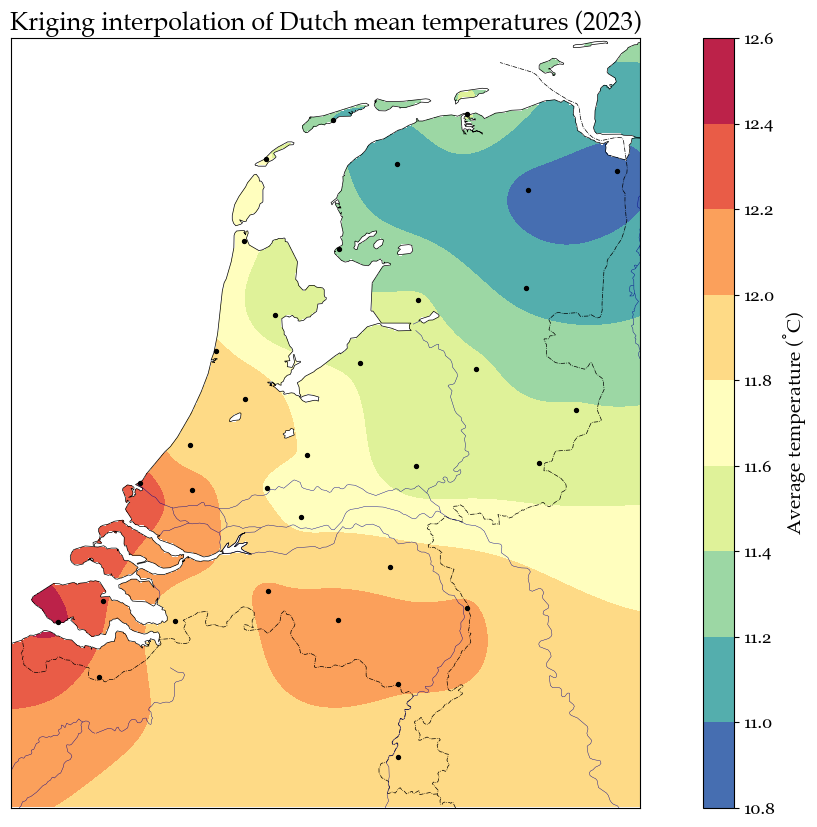

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define figure dimensions
fig = plt.figure(figsize=(15, 10))

ax = knmi_meteo_visualize.ordinary_kriging_nl_plot(
    stations_x, stations_y, values,
    cmap = "Spectral_r",
    variogram_model = "spherical",
    plot_title = f"Kriging interpolation of Dutch mean temperatures ({YEAR})",
    val_label = "Average temperature ($^{°}$C)")

fig.axes.append(ax)

# Show the plot
plt.show()

#### Observations
The average temperatures in the year of interest fall between 10.8 and 12.6 degrees. The lowest temperatures are encountered in the northeast, the highest close to the sea in the southwesternmost part (Zeeland province). In general the coastal areas seem to be slightly warmer than their more inland counterparts. The southeast area forms the sole exception to this pattern. This is probably because of the local relatively warmer summer days outweighing the slightly colder nights during the colder season - at least for 2023.

### Example 2.4: Spatial distribution of Dutch wind power in a given year

#### Introduction
Let's work through another similar example, but now for the spatial distribution of potential wind power throughout The Netherlands for a given year.

#### Obtain the raw dataset from the KNMI web service

Let's start by loading the hourly average wind speed (FH), in $m/s$, from the KNMI web service. This parameter is available in the hourly-based dataset which we will use below. 

Note that we need as short timespans as we can possibly get because of the cubic relation between wind speed and wind power: $P_{w} \propto v_{w}^{3}$.

As before we set 2023 as our year of interest. Again, feel free to change this to another year if desired. In the cells below the hourly data is loaded for each separate month, and then glued together using <code>pd.concat</code> over the list of DataFrames.

In [96]:
YEAR = 2023

In [97]:
# Get hourly wind data from KNMI web script service
df_windlist_m = []

for month in range(1, 13):
    
    # Set calendar logic of next month (for end date)
    if month < 12:
        end_year = YEAR
        end_month = month + 1
    else:
        end_year = YEAR + 1
        end_month = 1

    # Calculate first and last day of current month
    m_start_date = datetime.date(YEAR, month, 1)
    m_end_date = (datetime.date(end_year, end_month, 1) 
                  - datetime.timedelta(days=1))

    df_wind_m = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                   meteo_params_list=["FH"],
                                                   start_date=m_start_date,
                                                   end_date=m_end_date,
                                                   mode="hour")
    
    df_windlist_m.append(df_wind_m)

In [98]:
# Concatenate each monthly series to full year
df_wind_raw = pd.concat(df_windlist_m)

df_wind_raw

,STN,YYYYMMDD,HH,FH
0,209,20230101,1,140.0
1,209,20230101,2,130.0
2,209,20230101,3,140.0
3,209,20230101,4,120.0
4,209,20230101,5,130.0
...,...,...,...,...
34219,391,20231231,20,50.0
34220,391,20231231,21,50.0
34221,391,20231231,22,50.0
34222,391,20231231,23,40.0


#### Clean (transform) dataset
We can improve the readability of the dataset by applying some preset transformations on the "raw" dataset we just collected. We use the same recipe as in the earlier examples.

In [99]:
# Apply transformations to clean the raw dataset
df_wind = knmi_meteo_transform.transform_param_values(df_wind_raw)

In [100]:
# Show the result
df_wind

,station_code,date,hour,hour_avg_wind_speed,datetime
0,209,20230101,1,14.0,2023-01-01 00:00:00
1,209,20230101,2,13.0,2023-01-01 01:00:00
2,209,20230101,3,14.0,2023-01-01 02:00:00
3,209,20230101,4,12.0,2023-01-01 03:00:00
4,209,20230101,5,13.0,2023-01-01 04:00:00
...,...,...,...,...,...
34219,391,20231231,20,5.0,2023-12-31 19:00:00
34220,391,20231231,21,5.0,2023-12-31 20:00:00
34221,391,20231231,22,5.0,2023-12-31 21:00:00
34222,391,20231231,23,4.0,2023-12-31 22:00:00


#### Pivot the data

At this point we are left with a "long" format DataFrame, where each row in the DataFrame represents a single hour slot value for a given day and station. 

However, our desired DataFrame, should have the day as the index, the station as the column, and the hour slot as value ("wide" format).

In order to reformat the DataFrame as desired, we apply a pivot function in the cells below.

In [101]:
# Pivot data with 'datetime' as index, 'stn_code' as cols
df_wind_pivot = (df_wind
                 .pivot(index="datetime",
                        columns="station_code"))

# Flatten pivot table to single index
df_wind_pivot = df_wind_pivot["hour_avg_wind_speed"]

In [102]:
# Show the result
df_wind_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,14.0,11.0,15.0,12.0,11.0,16.0,12.0,14.0,14.0,NaN,...,11.0,10.0,12.0,9.0,11.0,11.0,11.0,9.0,10.0,5.0
2023-01-01 01:00:00,13.0,11.0,14.0,12.0,11.0,16.0,11.0,13.0,14.0,NaN,...,10.0,11.0,12.0,8.0,10.0,10.0,11.0,8.0,9.0,5.0
2023-01-01 02:00:00,14.0,11.0,16.0,12.0,12.0,15.0,13.0,14.0,13.0,NaN,...,11.0,10.0,11.0,7.0,9.0,10.0,9.0,8.0,9.0,4.0
2023-01-01 03:00:00,12.0,12.0,14.0,10.0,12.0,13.0,10.0,11.0,11.0,NaN,...,11.0,11.0,10.0,8.0,9.0,10.0,10.0,9.0,9.0,5.0
2023-01-01 04:00:00,13.0,11.0,15.0,10.0,12.0,13.0,10.0,11.0,10.0,NaN,...,8.0,9.0,10.0,7.0,8.0,9.0,10.0,9.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,15.0,10.0,16.0,13.0,11.0,15.0,13.0,10.0,13.0,NaN,...,9.0,9.0,10.0,8.0,9.0,8.0,8.0,10.0,11.0,5.0
2023-12-31 20:00:00,14.0,9.0,14.0,8.0,10.0,13.0,13.0,9.0,12.0,NaN,...,11.0,9.0,10.0,8.0,8.0,10.0,8.0,9.0,10.0,5.0
2023-12-31 21:00:00,11.0,10.0,11.0,8.0,11.0,10.0,12.0,7.0,11.0,NaN,...,11.0,10.0,10.0,8.0,9.0,9.0,9.0,6.0,9.0,5.0


#### Check missing data values per station

In [103]:
# Show counts of % of missing data for the stations
(df_wind_pivot.isnull().mean() * 100).value_counts()

0.000000      41
100.000000     1
1.495434       1
3.881279       1
4.634703       1
0.821918       1
Name: count, dtype: int64

#### Remove stations with > 1% missing data

The far majority of stations contain a full dataset for our year of interest. Some stations are missing a small portion of the hourly measurements.

Let's apply a filter on our DataFrame to always only keep stations having less than a certain percentage of missing data. As we are performing a summation of a highly variable parameter and because of the cubic relationship between wind speed and wind power ($P_{w} \propto v_{w}^{3}$), we set this threshold relatively strictly at 1%.

In [104]:
# Only keep stations with <1% of missing data hours
filter_cond = df_wind_pivot.isnull().mean() < .01
df_wind_sel = df_wind_pivot.loc[:, filter_cond]

#### Summarize dataset
In the cell below the wind speed dataset is summarized per station, and ordered descending based on the mean wind speed for our period of interest:

In [105]:
# Show summary of dataset
df_wind_sel.describe().T.sort_values(by="mean", 
                                     ascending=False)

,count,mean,std,min,25%,50%,75%,max
station_code,,,,,,,,
242,8760.0,7.856164,3.822658,0.0,5.0,7.0,10.0,22.0
285,8760.0,7.787329,3.556097,0.0,5.0,7.0,10.0,21.0
313,8760.0,7.748858,3.595063,0.0,5.0,8.0,10.0,24.0
225,8760.0,7.635616,3.920911,0.0,5.0,7.0,10.0,30.0
209,8760.0,7.597374,3.605772,0.0,5.0,7.0,10.0,28.0
330,8760.0,7.155708,3.339687,0.0,5.0,7.0,10.0,22.0
316,8688.0,7.057551,3.435090,0.0,4.0,7.0,9.0,22.0
310,8760.0,6.618721,3.436780,0.0,4.0,6.0,9.0,22.0
251,8760.0,6.430023,3.222486,0.0,4.0,6.0,8.0,20.0


#### Notes on wind speed data
The difference between the minimum and maximum mean wind speeds for our period of interest is a factor of ~3.3. This means that the wind power variability we would expect in the final map to be in the order of: $3.3^{3} \approx 36 $. This is quite a notable difference. 

That being said - time to proceed with our analysis:

In [106]:
# Show shape of remaining dataset
print(f"Rows (periods): {df_wind_sel.shape[0]} | "
      f"Cols (stations): {df_wind_sel.shape[1]}")

Rows (periods): 8760 | Cols (stations): 42


#### Convert sunshine to kWh per surface area; sum daily observations to totals

Just as for the solar irradiance from one of the earlier examples, the reporting format will be in unit $kWh/m^{2}$. However, to translate the wind speed (in $m/s$) to wind power per unit surface area (in $kWh/m^{2}$), the following formula is applicable:

$P_{w} = \frac{1}{2} \cdot \rho_{air} \cdot v_{w}^{3}$

In the calculation below we will assume a fixed air density at STP ($p=101.325$ $kPa$; $T=15$ $°C$), equal to 1.225 $kg/m^{3}$. Although this is not expected to lead to large deviations in the final calculation, this is still a simplification. In reality the air density is dependent on pressure $p$ and temperature $T$: $\rho_{air} = f(p,$ $T)$.

Furthermore we need to apply a correction factor of $1/1000$ to transform the output data from its inital unit of measurement, $m/s$, via the formula above to: $kg \cdot m^{-3} \cdot m^{3} \cdot s^{-3} \cdot h = (kg \cdot m^{2} \cdot s^{-2}) \cdot s^{-1} \cdot h \cdot m^{-2} = (J/s) \cdot h \cdot m^{-2} = Wh/m^{2}$, to $kWh/m^{2}$.

Note: we transformed $kg \cdot m^{2} \cdot s^{-2}$ to $J$ since $W [J] = m [kg] \cdot a[ms^{-2}] \cdot s[m]$. Similarly we transformed $J/s$ to $W$ since $P[W] = E[J] / t[s]$.

In [107]:
# Convert wind speed to wind power and sum to totals
air_density_stc = 1.225 # kg/m3

conv_to_kwh_m2 = 0.5 * air_density_stc / 1000
df_windpower = ((df_wind_sel ** 3).sum() 
                * conv_to_kwh_m2).round(1)

# Convert pd.Series to pd.DataFrame
df_windpower = (df_windpower.to_frame(name="wind_power")
                .reset_index())

In [108]:
df_windpower

,station_code,wind_power
0,209,4077.0
1,215,1148.5
2,225,4495.5
3,235,1794.9
4,240,1535.1
5,242,4626.3
6,248,1688.3
7,249,1438.5
8,251,2616.1
9,260,432.5


#### Merge station-based results with metadata for location pinpointing

In order to link the results we just obtained to their location on the map, we will load the station metadata as a dataset to merge on in the next steps:

In [109]:
# Get cleaned station (meta)data for adding lon, lat-data
df_stns = knmi_meteo_ingest.knmi_load_meteo_stations()
df_stns = knmi_meteo_transform.transform_stations(df_stns)

df_stns.head()

,station_code,longitude,latitude,altitude,location_name
0,209,4.518,52.465,0.0,IJmond
1,210,4.430,52.171,-0.2,Valkenburg Zh
2,215,4.437,52.141,-1.1,Voorschoten
3,225,4.555,52.463,4.4,IJmuiden
4,235,4.781,52.928,1.2,De Kooy


We apply the merge of results with stations locations using a "left join" on <code>station_code</code>, since we want to keep all results and get a NaN-location for a result (and not a drop of the result) in case a matching location is not found. This should not happen in our KNMI dataset, however.

In [110]:
# Merge station location (meta)data to our results
df_wind_stns = df_windpower.merge(df_stns, how="left", 
                                  on="station_code")
df_wind_stns.tail()

,station_code,wind_power,longitude,latitude,altitude,location_name
37,370,667.3,5.377,51.451,22.6,Eindhoven
38,375,671.3,5.707,51.659,22.0,Volkel
39,377,626.2,5.763,51.198,30.0,Ell
40,380,678.5,5.762,50.906,114.3,Maastricht
41,391,167.3,6.197,51.498,19.5,Arcen


#### Reformat locations and values to NumPy arrays
As a last preparation step before we set up our map visualization, we convert the $(x, y)$ locations of the stations and the output values (in this case: <code>wind_power</code>) from the DataFrame to NumPy arrays:

In [111]:
# Convert columns of interest to NumPy arrays
stations_x = df_wind_stns["longitude"].to_numpy()
stations_y = df_wind_stns["latitude"].to_numpy()
values = df_wind_stns["wind_power"].to_numpy()

print(f"Longitude range (deg): {stations_x.min()} - {stations_x.max()}; {stations_x.shape[0]} values")
print(f"Latitude range (deg): {stations_y.min()} - {stations_y.max()}; {stations_y.shape[0]} values")
print(f"Value range (kWh/m2): {values.min()} - {values.max()}; {values.shape[0]} values")

Longitude range (deg): 3.242 - 7.15; 42 values
Latitude range (deg): 50.906 - 53.575; 42 values
Value range (kWh/m2): 167.3 - 4626.3; 42 values


#### Creating the map
We will create a temperature map for The Netherlands for the period of interest using a helper function from script <code>knmi_meteo_visualize.py</code>. In this script, the $(x, y)$ locations of the stations and the observed values $(z)$ are required inputs.

By default, the script interpolates the measurements to a grid of 500 x 500 cells (<code>grid_dim_xy</code>), which may take some 10 to 30 seconds to complete. In case you desire a faster result (although this will lead to a visually slightly less appealing map), change this to e.g. 100 x 100 cells by setting <code>grid_dim_xy</code> to 100. 

For convergence purposes, the <code>variogram_model</code> is now set to "power". Given the cubic relationship between wind power and wind speed ($P_{w} \propto v_{w}^{3}$), this seemed to be the most logical choice in this case.

In case you obtain strange map results, consider changing the variogram model to another one. Also see the [PyKrige documentation ](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/variogram_models.html) for all variogram model options.

It is possible to change the colormap presented on the map. Furthermore you can change the marker look (size, style and color) of the observation locations.

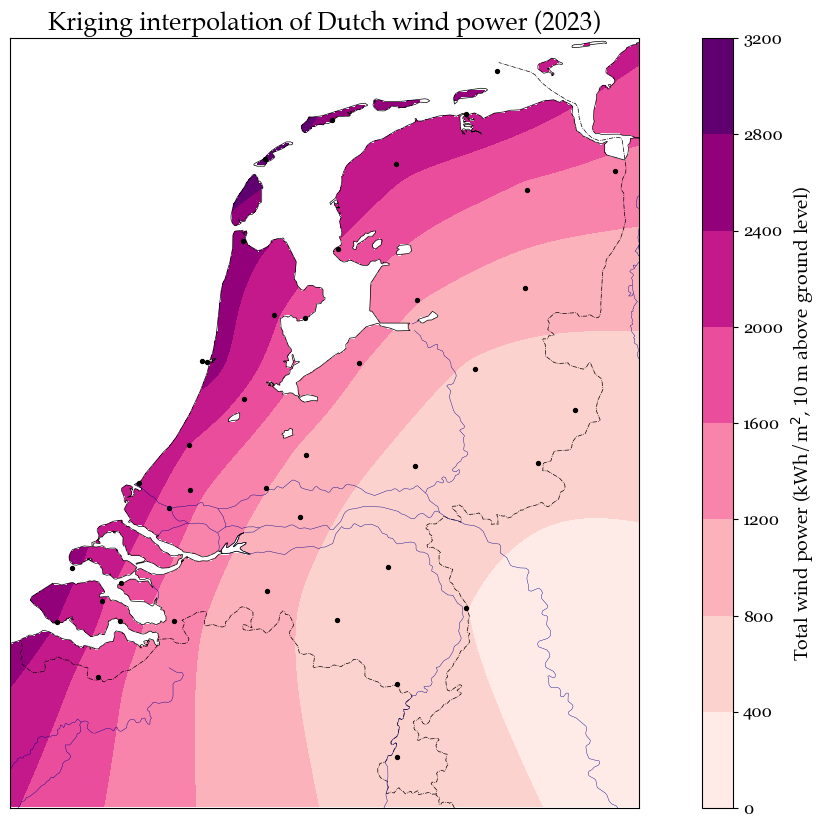

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define figure dimensions
fig = plt.figure(figsize=(15, 10))

ax = knmi_meteo_visualize.ordinary_kriging_nl_plot(
    stations_x, stations_y, values,
    cmap = "RdPu",
    variogram_model = "power",
    plot_title = f"Kriging interpolation of Dutch wind power ({YEAR})",
    val_label = "Total wind power (kWh/m$^{2}$, 10 m above ground level)")

fig.axes.append(ax)

# Show the plot
plt.show()

#### Observations
The disparity between the coastal and far inland values for the wind power strikes the eye immediately. In the entire east- to southeastern portion of the country, the wind power for 2023 at a height of 10 m above ground level is (well) below 800 $kWh/m^{2}$, with the lowest value east of Limburg falling even below the 400 $kWh/m^{2}$ threshold. Meanwhile the coastal regions show ranges around 2000 - 2500 $kWh/m^{2}$, with a peak above 3000 $kWh/m^{2}$ at the Wadden island of Vlieland. The values on the offshore measurement stations even exceed 4000 $kWh/m^{2}$. However, this does not show up on the map because the cell values at sea were filtered out. This is because it would become a lot harder to read the map without applying this filter.

In short, when planning for wind parks, it seems like it would make most sense to do this as close to the sea as possible for optimal energy yields.

#### Notes
- The values shown are for a hub height of 10 meters, which is lower than the expected values on typical wind farm hub heights (which nowadays would be more in the range of 50 - 100 meters). The [wind profile power law](https://en.wikipedia.org/wiki/Wind_profile_power_law) or the [log wind profile](https://en.wikipedia.org/wiki/Log_wind_profile) could be used to translate the measured wind speeds to the (higher) wind speeds at greater altitude.
- For modeling the actual energy yield on wind farms it is recommended to use power curves to translate wind speeds directly to energy outputs.
- For more fine-grained long-term energy modeling it is possible to fit the local wind speed histograms to a so-called [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution). In this way, the dataset will become a smooth distribution, which makes further analysis easier.

## Summary Overview
Hopefully the hands-on examples expanded your confidence to play around with similar data analysis workflows.

We delved deep into uncovering underlying patterns for rainfall, temperature, wind and solar irradiance.

<em>TODO: IMPROVE TEXT</em>

## Closing notes
Fantastic job on reaching the end of this Notebook! 

We have seen many different visualizations and derived countless insights, both from a temporal and from a spatial perspective.

<em>TODO: IMPROVE TEXT</em>

In the [next Notebook in the series](./03-knmi_spi_spei_analysis.ipynb), we will use KNMI weather data to create a whole new dataset that will enable us to assess the intensity of drought and wetness throughout the years. Very happy to see you there!